In [6]:
#in this script we are extracting and processing the read files for the w6 ishiguro ATO data, and performing QC
import scanpy as sc
import anndata as ad
import pandas as pd
import os

In [7]:
from scipy.io import mmread
from scipy.sparse import csr_matrix

In [8]:
# Define the path to the directory containing your files
data_dir = '/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/ishiguro_ato/unprocessed/'

# Define the paths to the individual files
matrix_path = f'{data_dir}counts.mtx'
barcodes_path = f'{data_dir}counts.barcodes.txt'
features_path = f'{data_dir}features.tsv' # <-- Use your new, updated gene file

In [9]:
# 1. Read the counts matrix
# mmread loads it into a coordinate-style sparse matrix (COO)
counts_coo = mmread(matrix_path)

In [10]:
counts_coo.shape #outputs rownum, colnum
#from this rows = cells, col = genes

(1232447, 86364)

In [11]:
# Convert it to a Compressed Sparse Row (CSR) matrix for faster computations
# The .T transposes the matrix because 10x format is (genes x cells),
# but AnnData expects (cells x genes).
counts_csr = csr_matrix(counts_coo)

In [12]:
# 2. Read the cell barcodes
# read_csv is used here. We specify no header and get the first column.
barcodes_df = pd.read_csv(barcodes_path, header=None, sep='\t')
cell_names = barcodes_df[0].tolist()

# 3. Read your new gene features file
# This file has 3 columns: Ensembl ID, Gene Symbol, Feature Type
features_df = pd.read_csv(features_path, header=None, sep='\t')
# Assign column names for clarity
features_df.columns = ['gene_id', 'gene_symbol', 'feature_type']

# Set the unique Ensembl IDs as the index of the dataframe
features_df = features_df.set_index('gene_id')

In [13]:
# Create the AnnData object
# The main data (X) is the counts matrix
# obs corresponds to cells (observations)
# var corresponds to genes (variables)
adata = sc.AnnData(X=counts_csr,
                   obs=pd.DataFrame(index=cell_names),
                   var=features_df)

In [14]:
# Print the object to see its dimensions and contents
print(adata)

# Check the cell names (observation names)
print("\nCell names (adata.obs):")
print(adata.obs.head())

# Check the gene information (variable annotations)
# This should show your Ensembl IDs as the index and your new HGNC symbols
# in the 'gene_symbol' column.
print("\nGene names (adata.var):")
print(adata.var.head())

AnnData object with n_obs × n_vars = 1232447 × 86364
    var: 'gene_symbol', 'feature_type'

Cell names (adata.obs):
Empty DataFrame
Columns: []
Index: [AAACCCAAGACCAAGC, AAACCCAAGCACAAAT, AAACCCAAGCACACCC, AAACCCAAGCACCTGT, AAACCCAAGCCGATAG]

Gene names (adata.var):
                     gene_symbol     feature_type
gene_id                                          
ENSG00000290825  ENSG00000290825  Gene Expression
ENSG00000223972          DDX11L1  Gene Expression
ENSG00000310526           WASH7P  Gene Expression
ENSG00000227232           WASH7P  Gene Expression
ENSG00000278267        MIR6859-1  Gene Expression


In [15]:
# Set the gene_symbol column as the primary index for adata.var
adata.var_names = adata.var['gene_symbol']

# Make the var_names (the gene symbols) unique
adata.var_names_make_unique()

# Check the result. You'll see WASH7P, WASH7P-1, etc.
print(adata.var.head())

                     gene_symbol     feature_type
gene_symbol                                      
ENSG00000290825  ENSG00000290825  Gene Expression
DDX11L1                  DDX11L1  Gene Expression
WASH7P                    WASH7P  Gene Expression
WASH7P-1                  WASH7P  Gene Expression
MIR6859-1              MIR6859-1  Gene Expression


In [16]:
#now that we have loaded up the countdata and metadata, we can proceed with QC
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

In [17]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

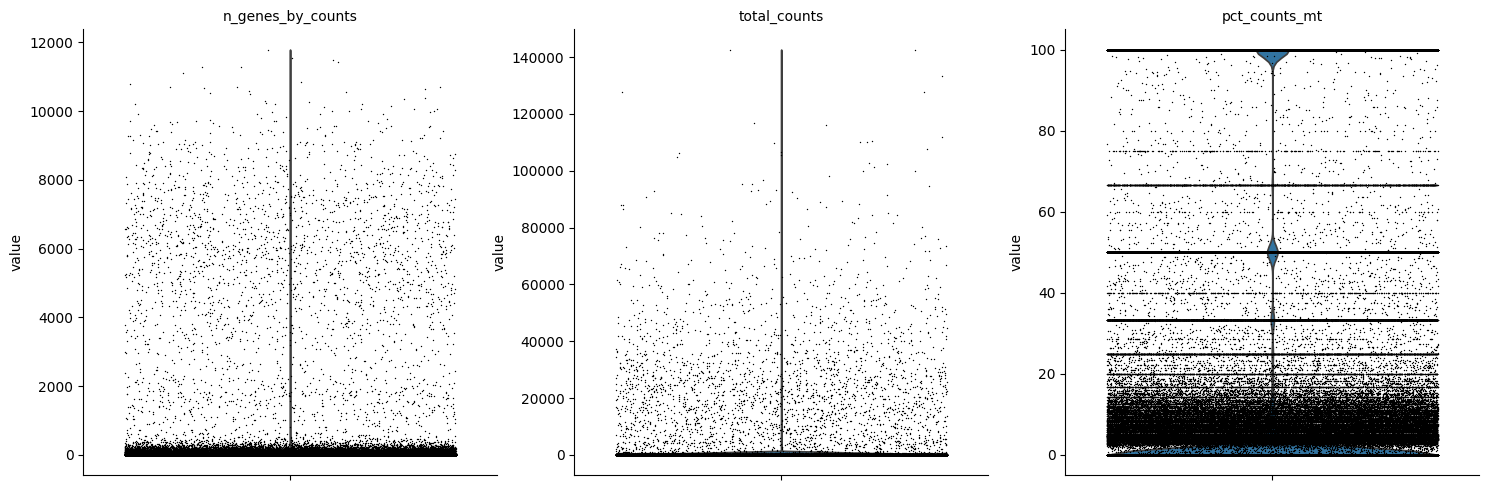

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

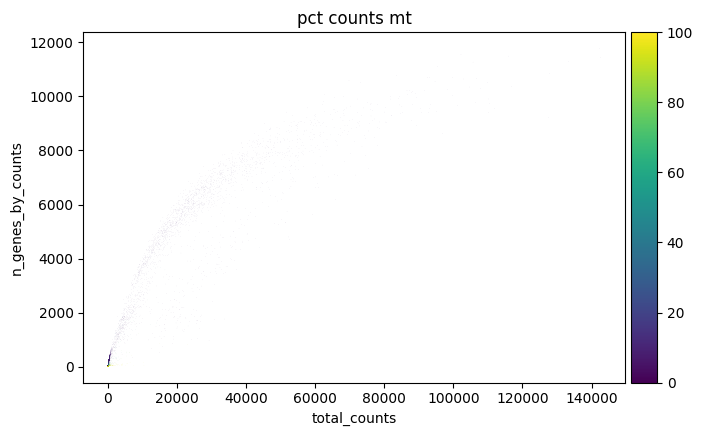

In [19]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [20]:
#No QC or filtering has been done to the above cells, we will firstly filter with low stringency
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 20].copy()

In [21]:
print(adata)

AnnData object with n_obs × n_vars = 9200 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


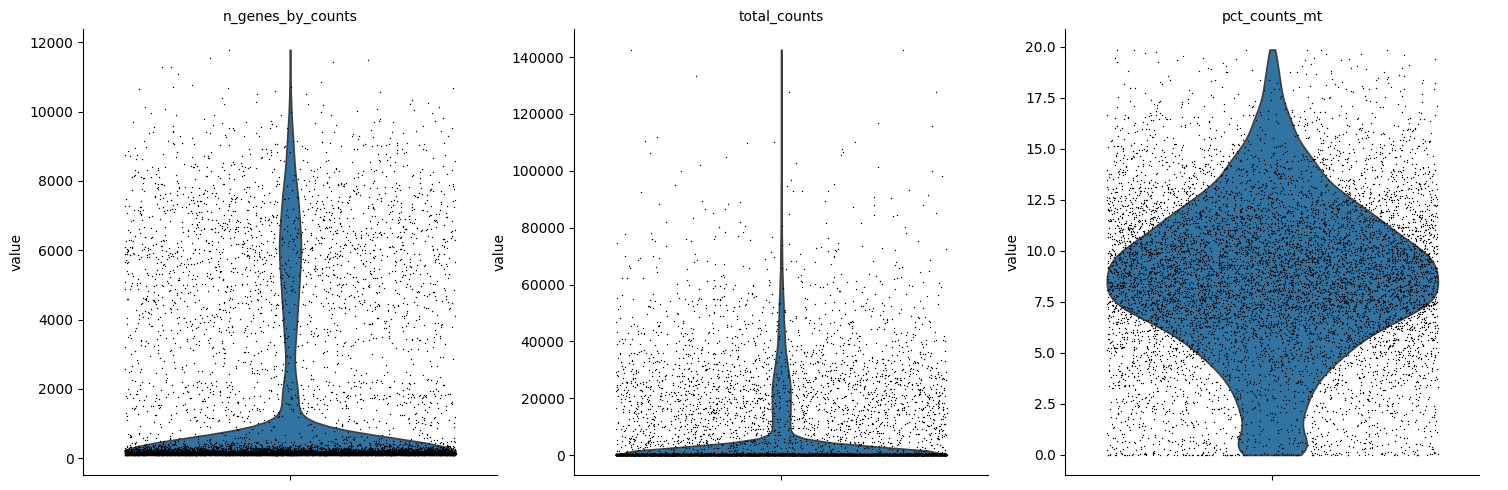

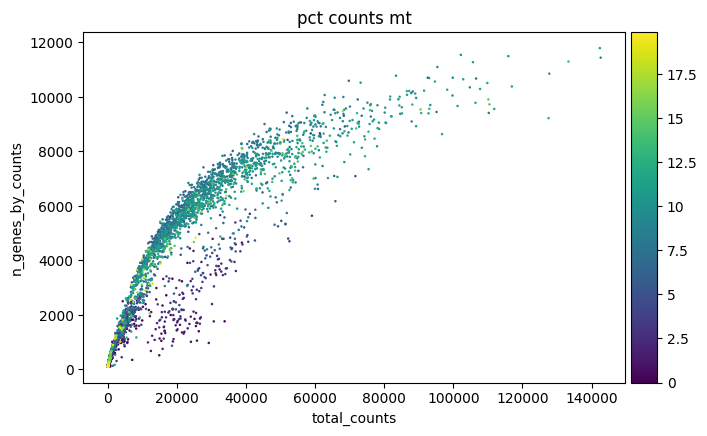

In [22]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [23]:
#store the original expression data
adata.layers["counts"] = adata.X.copy()

In [24]:
#gonna visualise to see if the low quality cells form a community
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.leiden(adata)

/g/data/yr31/hb1618/iPSC_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/jobfs/149855643.gadi-pbs/ipykernel_242367/3043749299.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [26]:
sc.tl.umap(adata)

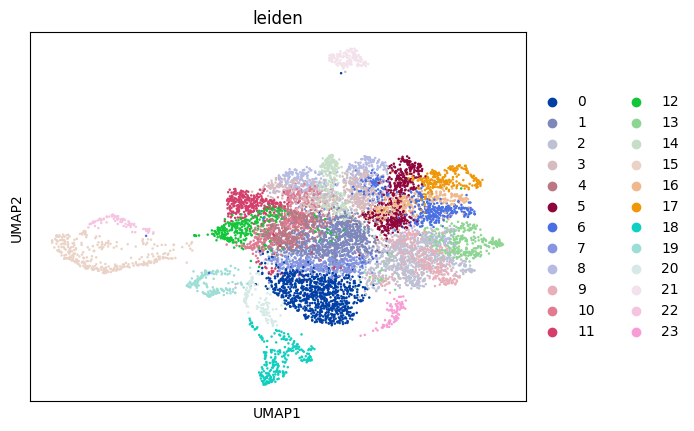

In [27]:
sc.pl.umap(adata, color=["leiden"], legend_loc = 'right margin')

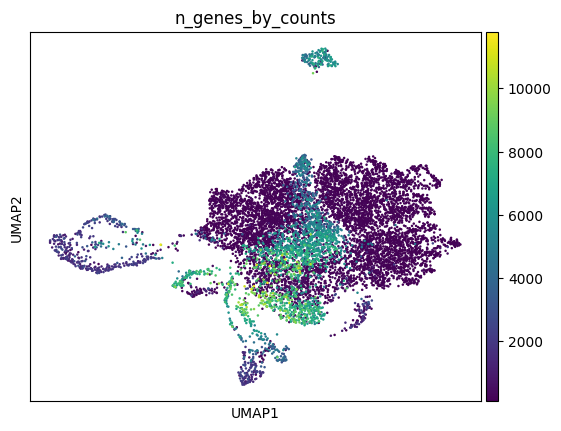

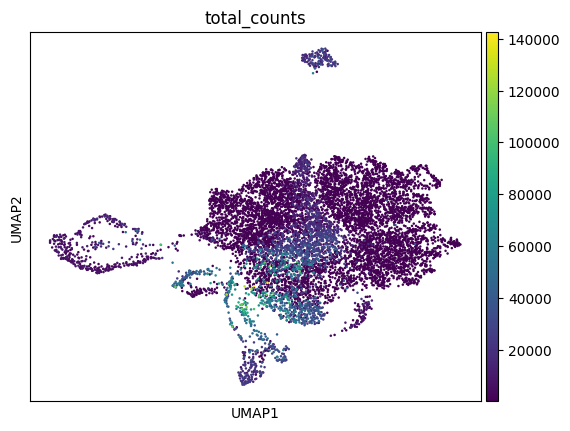

In [28]:
sc.pl.umap(adata, color=["n_genes_by_counts"], legend_loc = 'right margin')
sc.pl.umap(adata, color=["total_counts"], legend_loc = 'right margin')


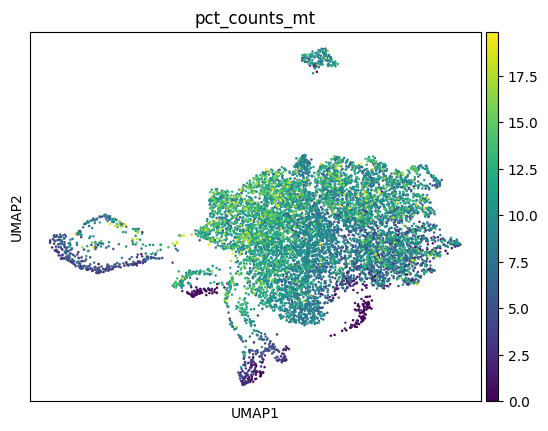

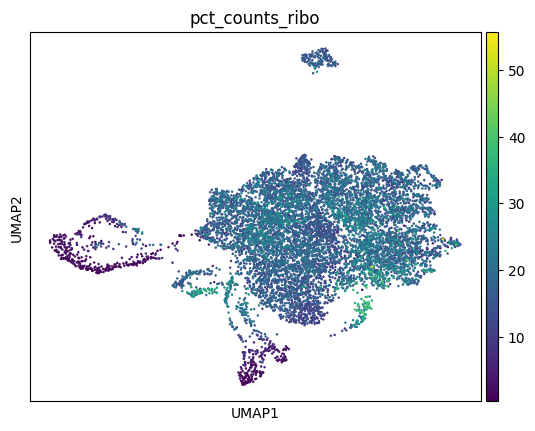

In [29]:


# Now plot it on your UMAP
sc.pl.umap(adata, color=["pct_counts_mt"], legend_loc = 'right margin')
sc.pl.umap(adata, color='pct_counts_ribo')

In [30]:
#filtering for low gene counts
sc.pp.filter_cells(adata, min_genes=500)

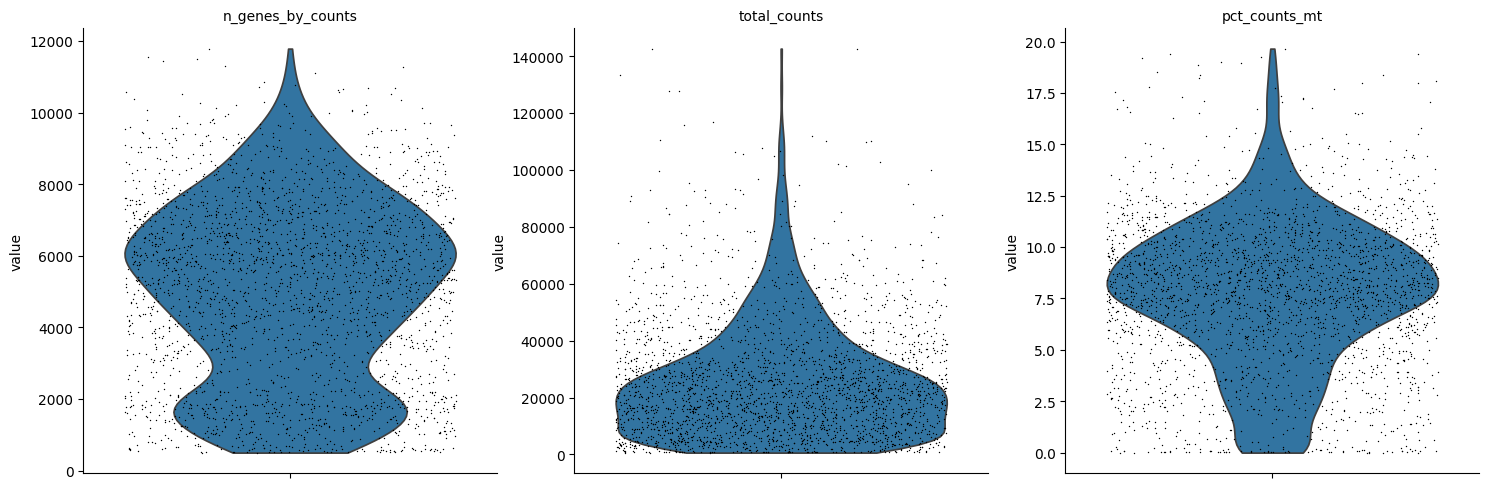

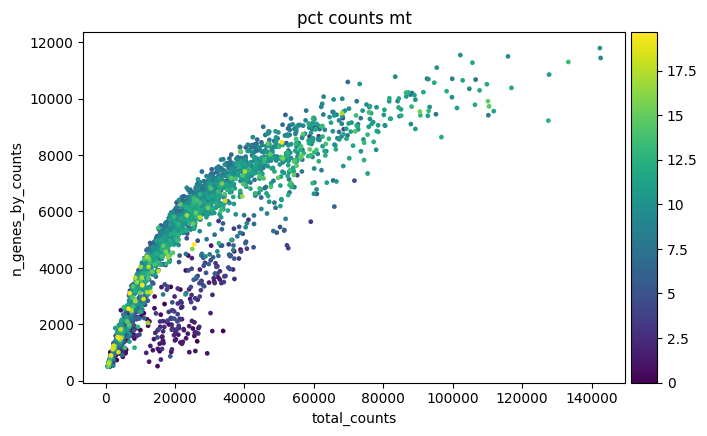

In [31]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

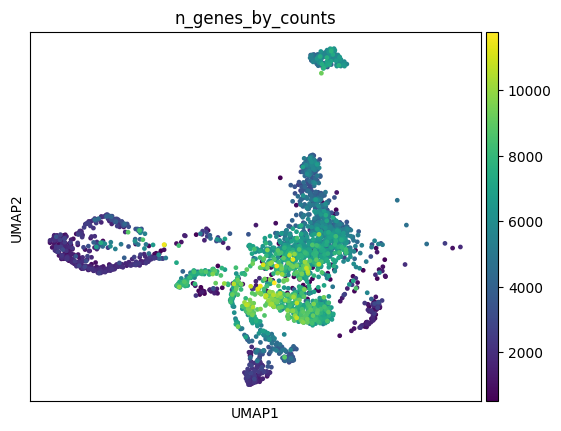

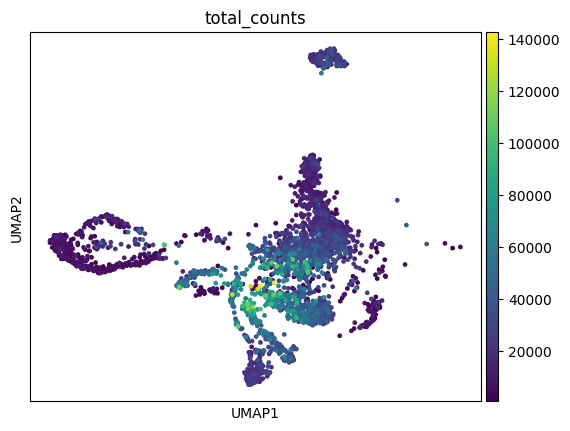

In [32]:
sc.pl.umap(adata, color=["n_genes_by_counts"], legend_loc = 'right margin')
sc.pl.umap(adata, color=["total_counts"], legend_loc = 'right margin')

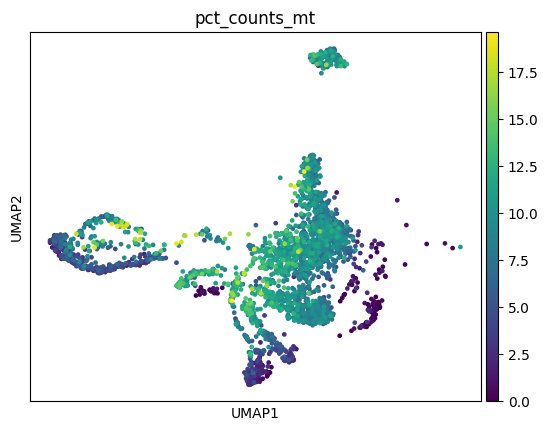

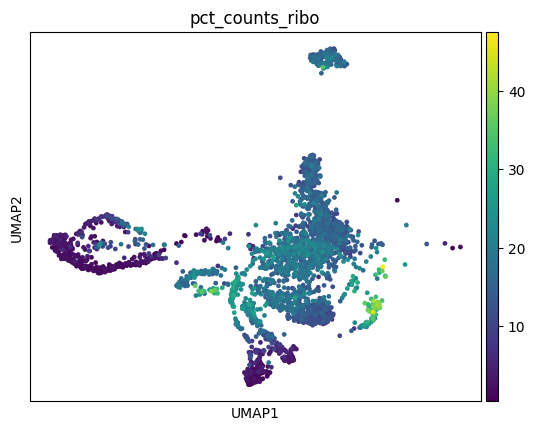

In [33]:
sc.pl.umap(adata, color=["pct_counts_mt"], legend_loc = 'right margin')
sc.pl.umap(adata, color=["pct_counts_ribo"], legend_loc = 'right margin')

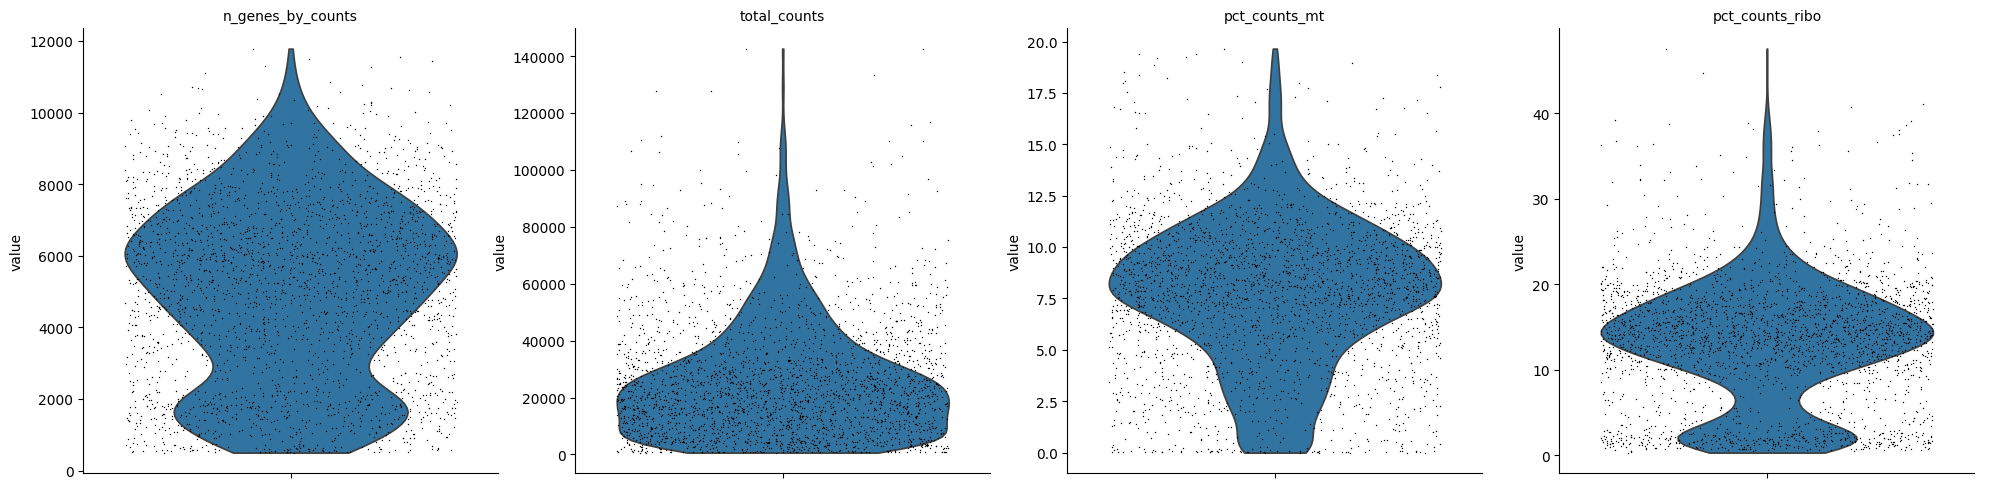

In [34]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

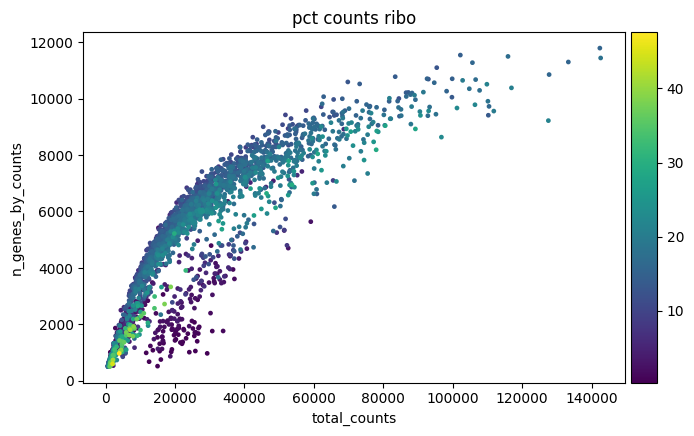

In [35]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

In [36]:
#filtering to remove high mt %, low rb % and high rb %
adata = adata[adata.obs['pct_counts_mt'] < 15].copy()
adata = adata[adata.obs['pct_counts_ribo'] < 30].copy()
adata = adata[adata.obs['pct_counts_ribo'] > 5].copy()

In [37]:
print(adata)

AnnData object with n_obs × n_vars = 2026 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


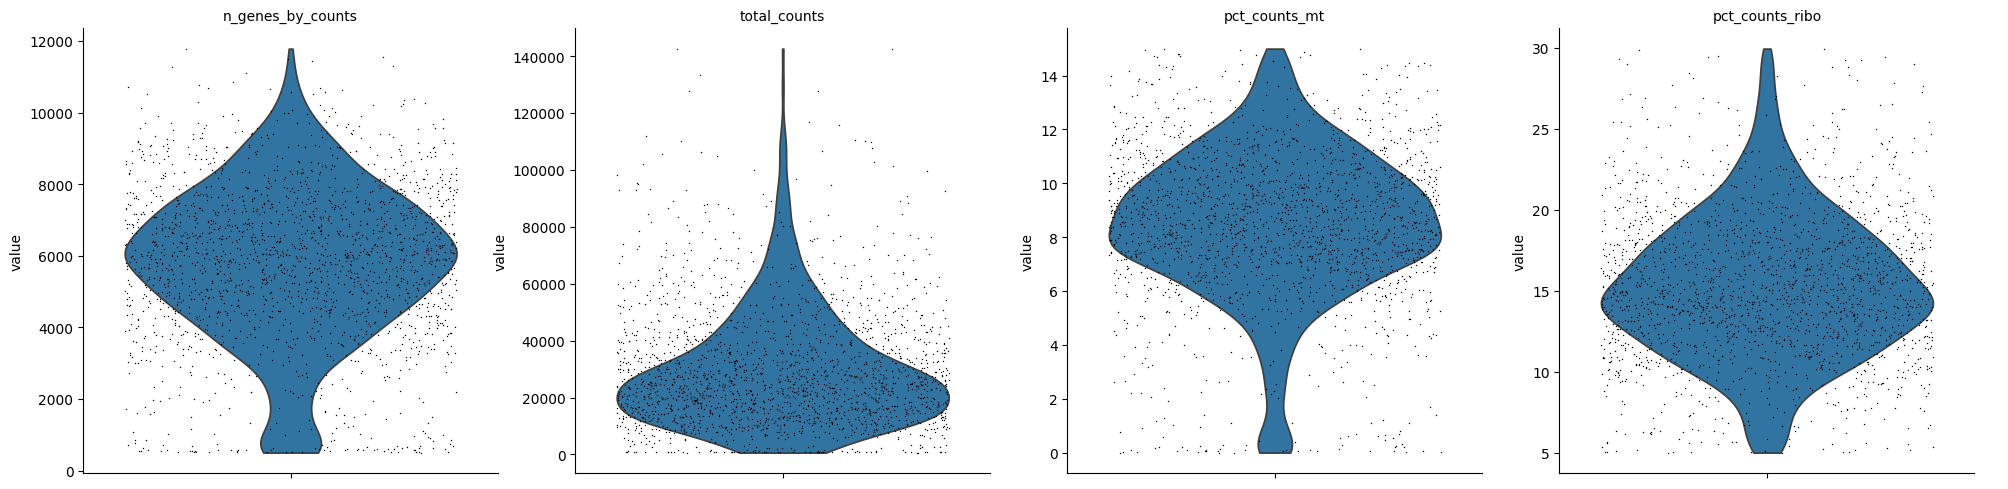

In [38]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

In [39]:
print(adata)

AnnData object with n_obs × n_vars = 2026 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


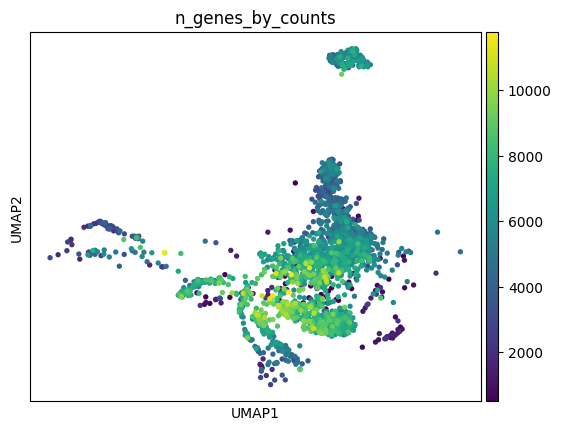

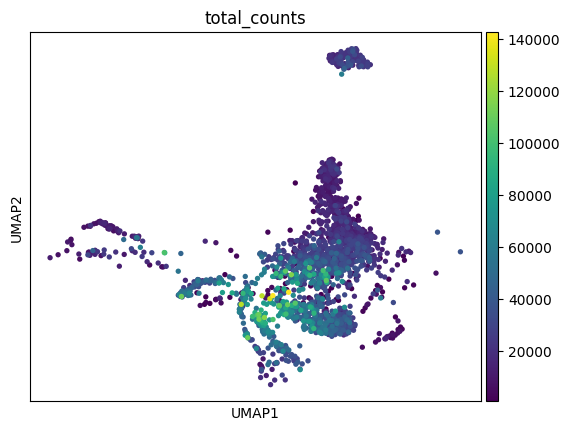

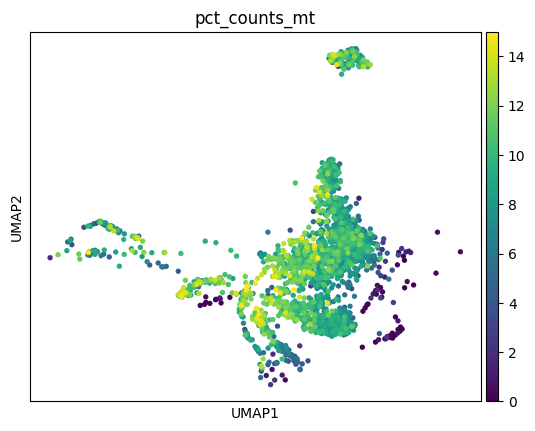

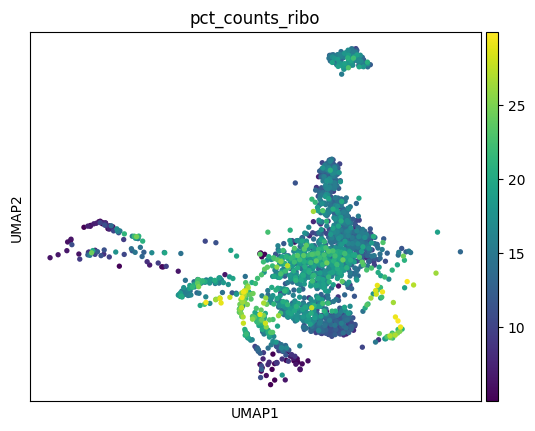

In [40]:
sc.pl.umap(adata, color='n_genes_by_counts')
sc.pl.umap(adata, color='total_counts')
sc.pl.umap(adata, color='pct_counts_mt')
sc.pl.umap(adata, color='pct_counts_ribo')

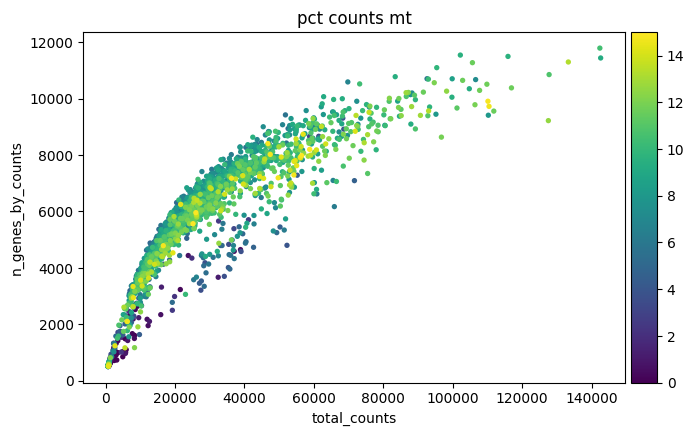

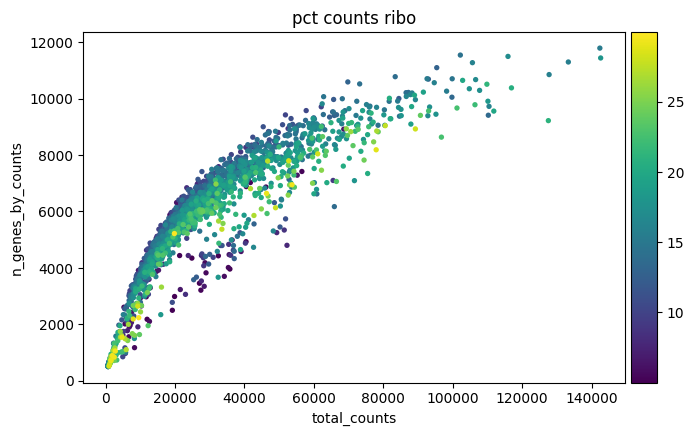

In [41]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

In [42]:
#gonna raise the min_gene threshold slightly and add a min_mt threshold
sc.pp.filter_cells(adata, min_genes=600)
adata = adata[adata.obs["pct_counts_mt"] > 0.25].copy()

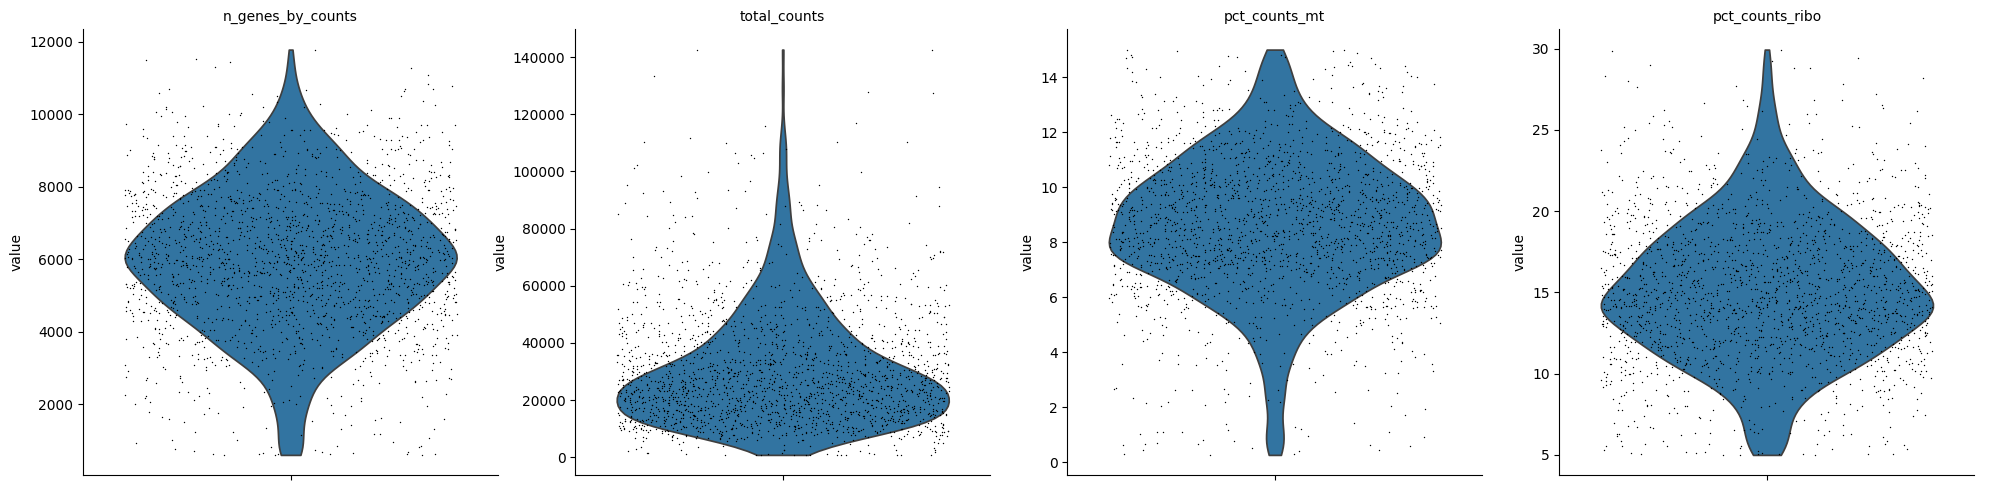

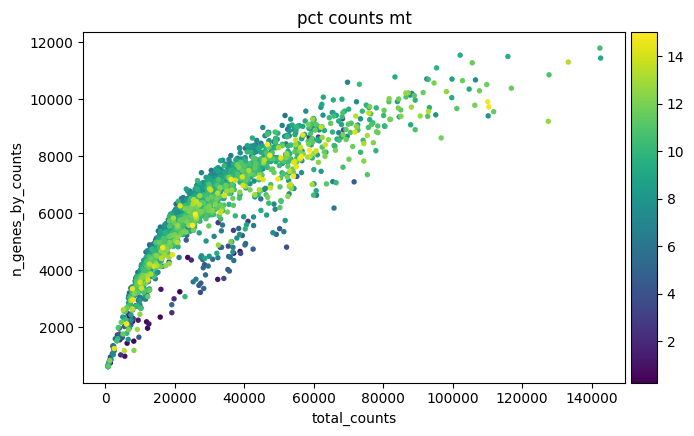

In [43]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

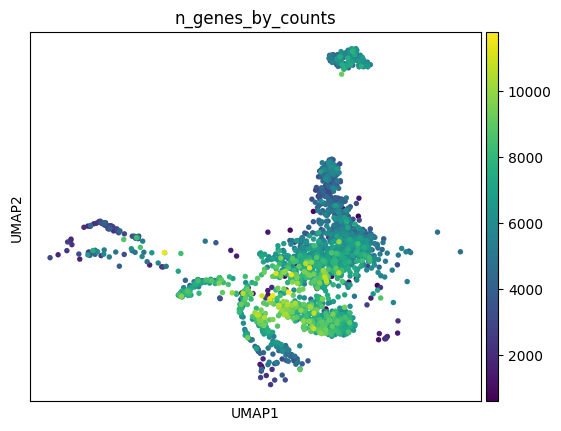

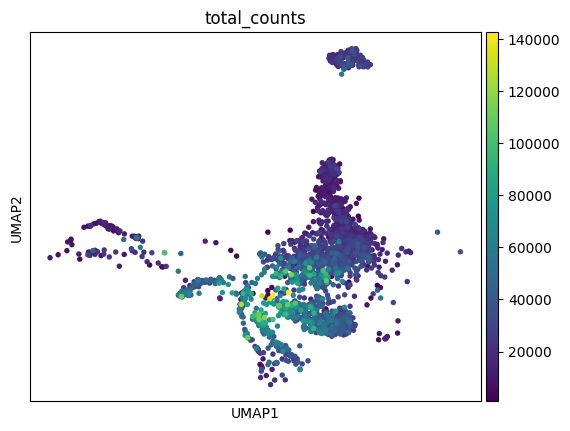

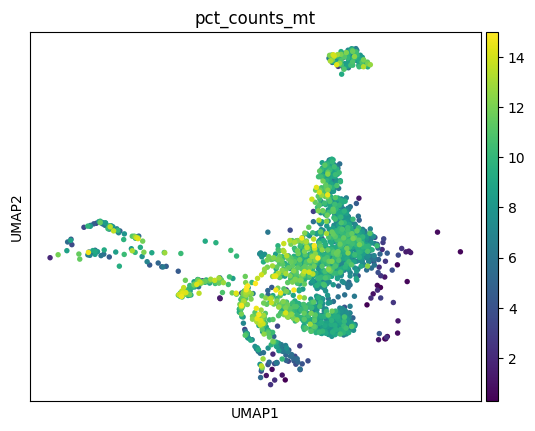

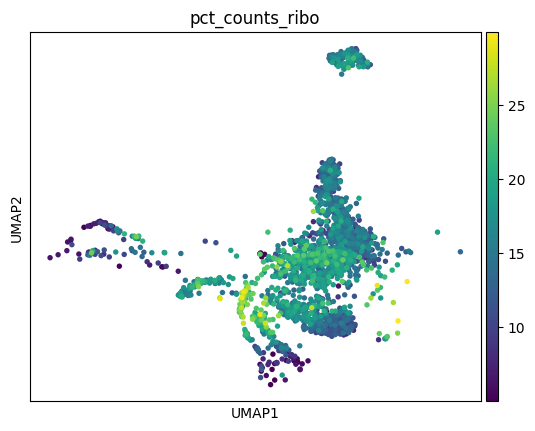

In [44]:
sc.pl.umap(adata, color='n_genes_by_counts')
sc.pl.umap(adata, color='total_counts')
sc.pl.umap(adata, color='pct_counts_mt')
sc.pl.umap(adata, color='pct_counts_ribo')

In [45]:
print(adata)

AnnData object with n_obs × n_vars = 1954 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [46]:
#proceeding with scrublet
#now run scrublet to detect potential doublet cells
sc.pp.scrublet(adata)

In [47]:
print(adata)

AnnData object with n_obs × n_vars = 1954 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'doublet_score', 'predicted_doublet'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'scrublet'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


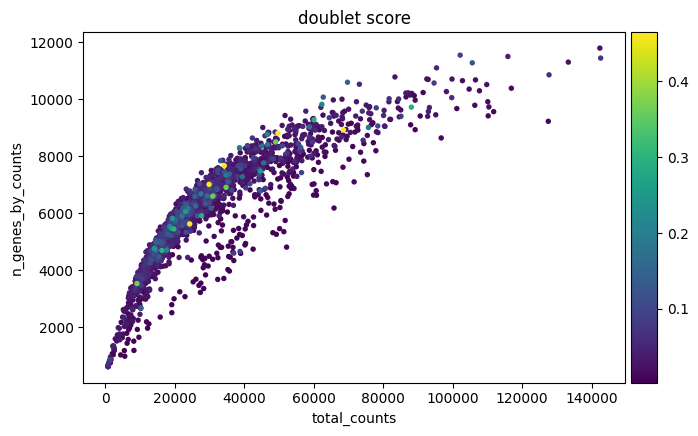

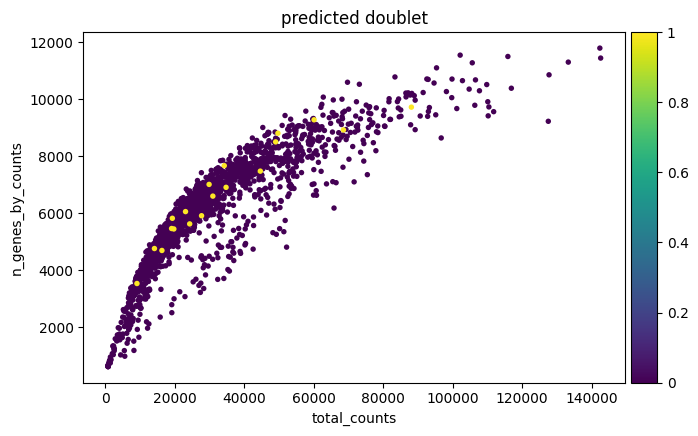

In [48]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="predicted_doublet")

In [49]:
adata = adata[adata.obs['predicted_doublet'] == False].copy()
adata = adata[adata.obs['total_counts'] < 110000].copy()

In [50]:
print(adata)

AnnData object with n_obs × n_vars = 1924 × 40665
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'doublet_score', 'predicted_doublet'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'scrublet'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


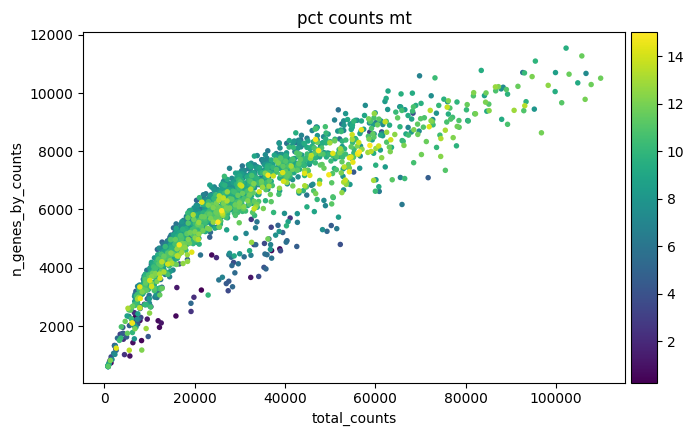

In [51]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

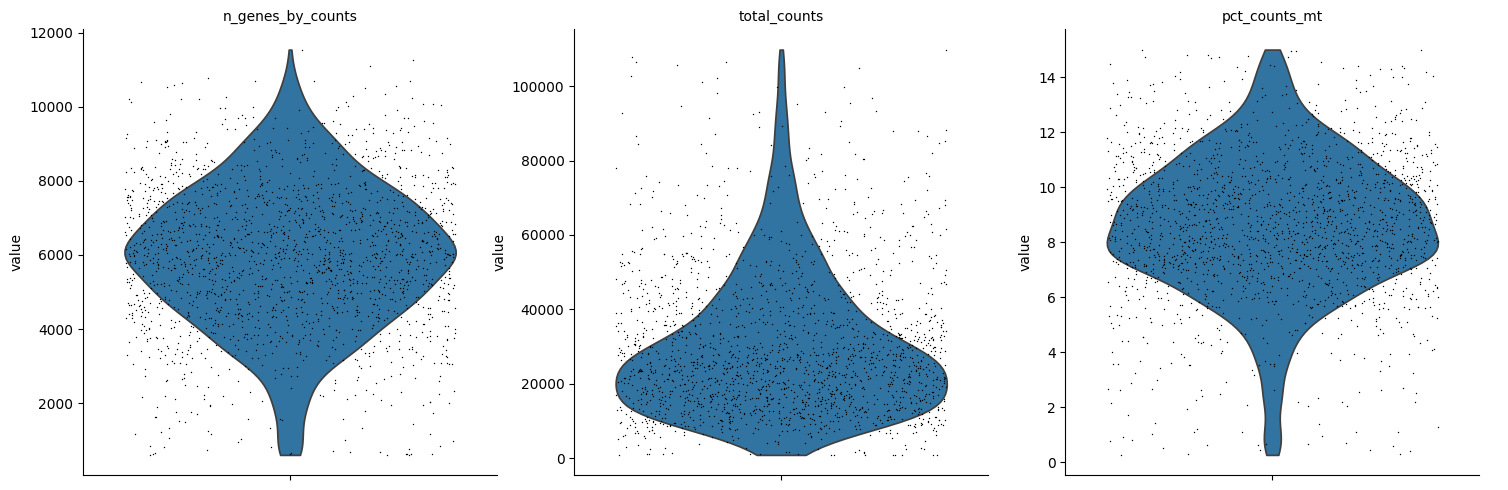

In [52]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [53]:
#now filtering genes
#n_cells = adata.n_obs
#threshold = round(n_cells * 0.05)
#sc.pp.filter_genes(adata, min_cells=threshold)
sc.pp.filter_genes(adata, min_cells=3)

In [54]:
print(adata)

AnnData object with n_obs × n_vars = 1924 × 39494
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'doublet_score', 'predicted_doublet'
    var: 'gene_symbol', 'feature_type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'scrublet'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [55]:
#From here we save our obj as a tsv and csv
#exporting extracted data
#exporting count data
# Extract the data from the 'counts' layer of your subsetted object
counts_matrix = adata.layers["counts"]

# Create the DataFrame
# The logic to handle sparse vs. dense arrays is still good to have
counts_df = pd.DataFrame(
    counts_matrix.toarray() if hasattr(counts_matrix, 'toarray') else counts_matrix,
    index=adata.obs_names,
    columns=adata.var_names
)


In [56]:
# Save the DataFrame to a .tsv file
counts_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/ishiguro_ato/w6/processed/countdata.tsv", sep='\t')